# PIB

## Packages

### Libraries

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import time
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta


# For creating cool charts :)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from matplotlib import image
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

In [2]:
import locale
locale.setlocale(locale.LC_ALL, 'es_es')

'es_es'

### Customized functions

In [3]:
# Filter dataframe by date range or for two specific dates
def date_selection(data_frame,first_date,last_date,inbewtween):
    if inbewtween==True:
        data_frame = data_frame[(data_frame["date"] >= first_date) & (data_frame["date"] <= last_date)].reset_index(drop = True)
    else:
        data_frame = data_frame[(data_frame["date"] == first_date) | (data_frame["date"] == last_date)].reset_index(drop = True)
    return(data_frame)

# Return last date for any dataframe with a 'date' columns
def last_date(dataframe):
    x= dataframe['date'].tail(1).dt.strftime('%Y-%m-%d').to_string()[-10:]
    return(x)

## (A) Overall

#### Payload

In [4]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "economic_activity"
    ],
    "categories": {
        "economic_activity": [
            "dfeefc621d16d0c"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_gdp_national",
            "variables": [
                "675882bced9ce54" #deflated
            ]
        }
    ],
    "from": "1999-01-01"
}

response = get_tukan_api_request(payload)
gdp = response["data"]
# gdp

Success getting the data


In [5]:
#n Load new fonts
# Load the Comfortaa style

path = [x for x in sys.path if "assets" in x][0] + "\\fonts\\Teko\\"

for x in os.listdir(path):
    if x.split(".")[-1] == "ttf":
        fm.fontManager.addfont(path + "/" + x)
        try:
            fm.FontProperties(weight=x.split(
                "-")[-1].split(".")[0].lower(), fname=x)
        except:
            x

path = [x for x in sys.path if "assets" in x][0] + "\\fonts\\Dosis\\"

for x in os.listdir(path):
    if x.split(".")[-1] == "ttf":
        fm.fontManager.addfont(path + "/" + x)
        try:
            fm.FontProperties(weight=x.split(
                "-")[-1].split(".")[0].lower(), fname=x)
        except:
            x

### Quarterly

#### Filter

In [6]:
# Data
filtered_gdp = gdp.copy()

# Units in millions
filtered_gdp['675882bced9ce54'] = filtered_gdp['675882bced9ce54']/1000000000

# Quarterly variation
filtered_gdp['qrtr_var'] = filtered_gdp.groupby(['economic_activity__ref'])['675882bced9ce54'].shift()
filtered_gdp['qrtr_var'] = (filtered_gdp['675882bced9ce54']/filtered_gdp['qrtr_var'])-1

# Yearly variation
filtered_gdp['year_var'] = filtered_gdp.groupby(['economic_activity__ref'])['675882bced9ce54'].shift(4)
filtered_gdp['year_var'] = (filtered_gdp['675882bced9ce54']/filtered_gdp['year_var'])-1

# Date filters
first_date = '2016-01-01'
second_date = last_date(filtered_gdp)
filtered_gdp = date_selection(filtered_gdp,first_date,second_date, True)

# Filtered data
filtered_gdp.tail(3)
# filtered_gdp

,date,economic_activity__ref,economic_activity,675882bced9ce54,qrtr_var,year_var
21,2021-04-01,dfeefc621d16d0c,Actividad económica,17996.822693,0.035596,0.198739
22,2021-07-01,dfeefc621d16d0c,Actividad económica,17564.773900,-0.024007,0.045207
23,2021-10-01,dfeefc621d16d0c,Actividad económica,18220.946733,0.037357,0.011002


#### Estimate

In [7]:
# Adding estimate
# eopib_qrtr_est = -0.001
# eopib_yrtr_est = 0.05

# gdp_estimate = {'date': datetime(2021, 10, 1), 'economic_activity__ref': 'dfeefc621d16d0c', 'economic_activity': 'Actividad económica', '675882bced9ce54':float(filtered_gdp['675882bced9ce54'].tail(1).values)*(1+eopib_qrtr_est),'qrtr_var':eopib_qrtr_est,'year_var':eopib_yrtr_est}

# filtered_gdp = filtered_gdp.append(gdp_estimate, ignore_index = True)
# filtered_gdp.tail(3)

#### YoY % Plot

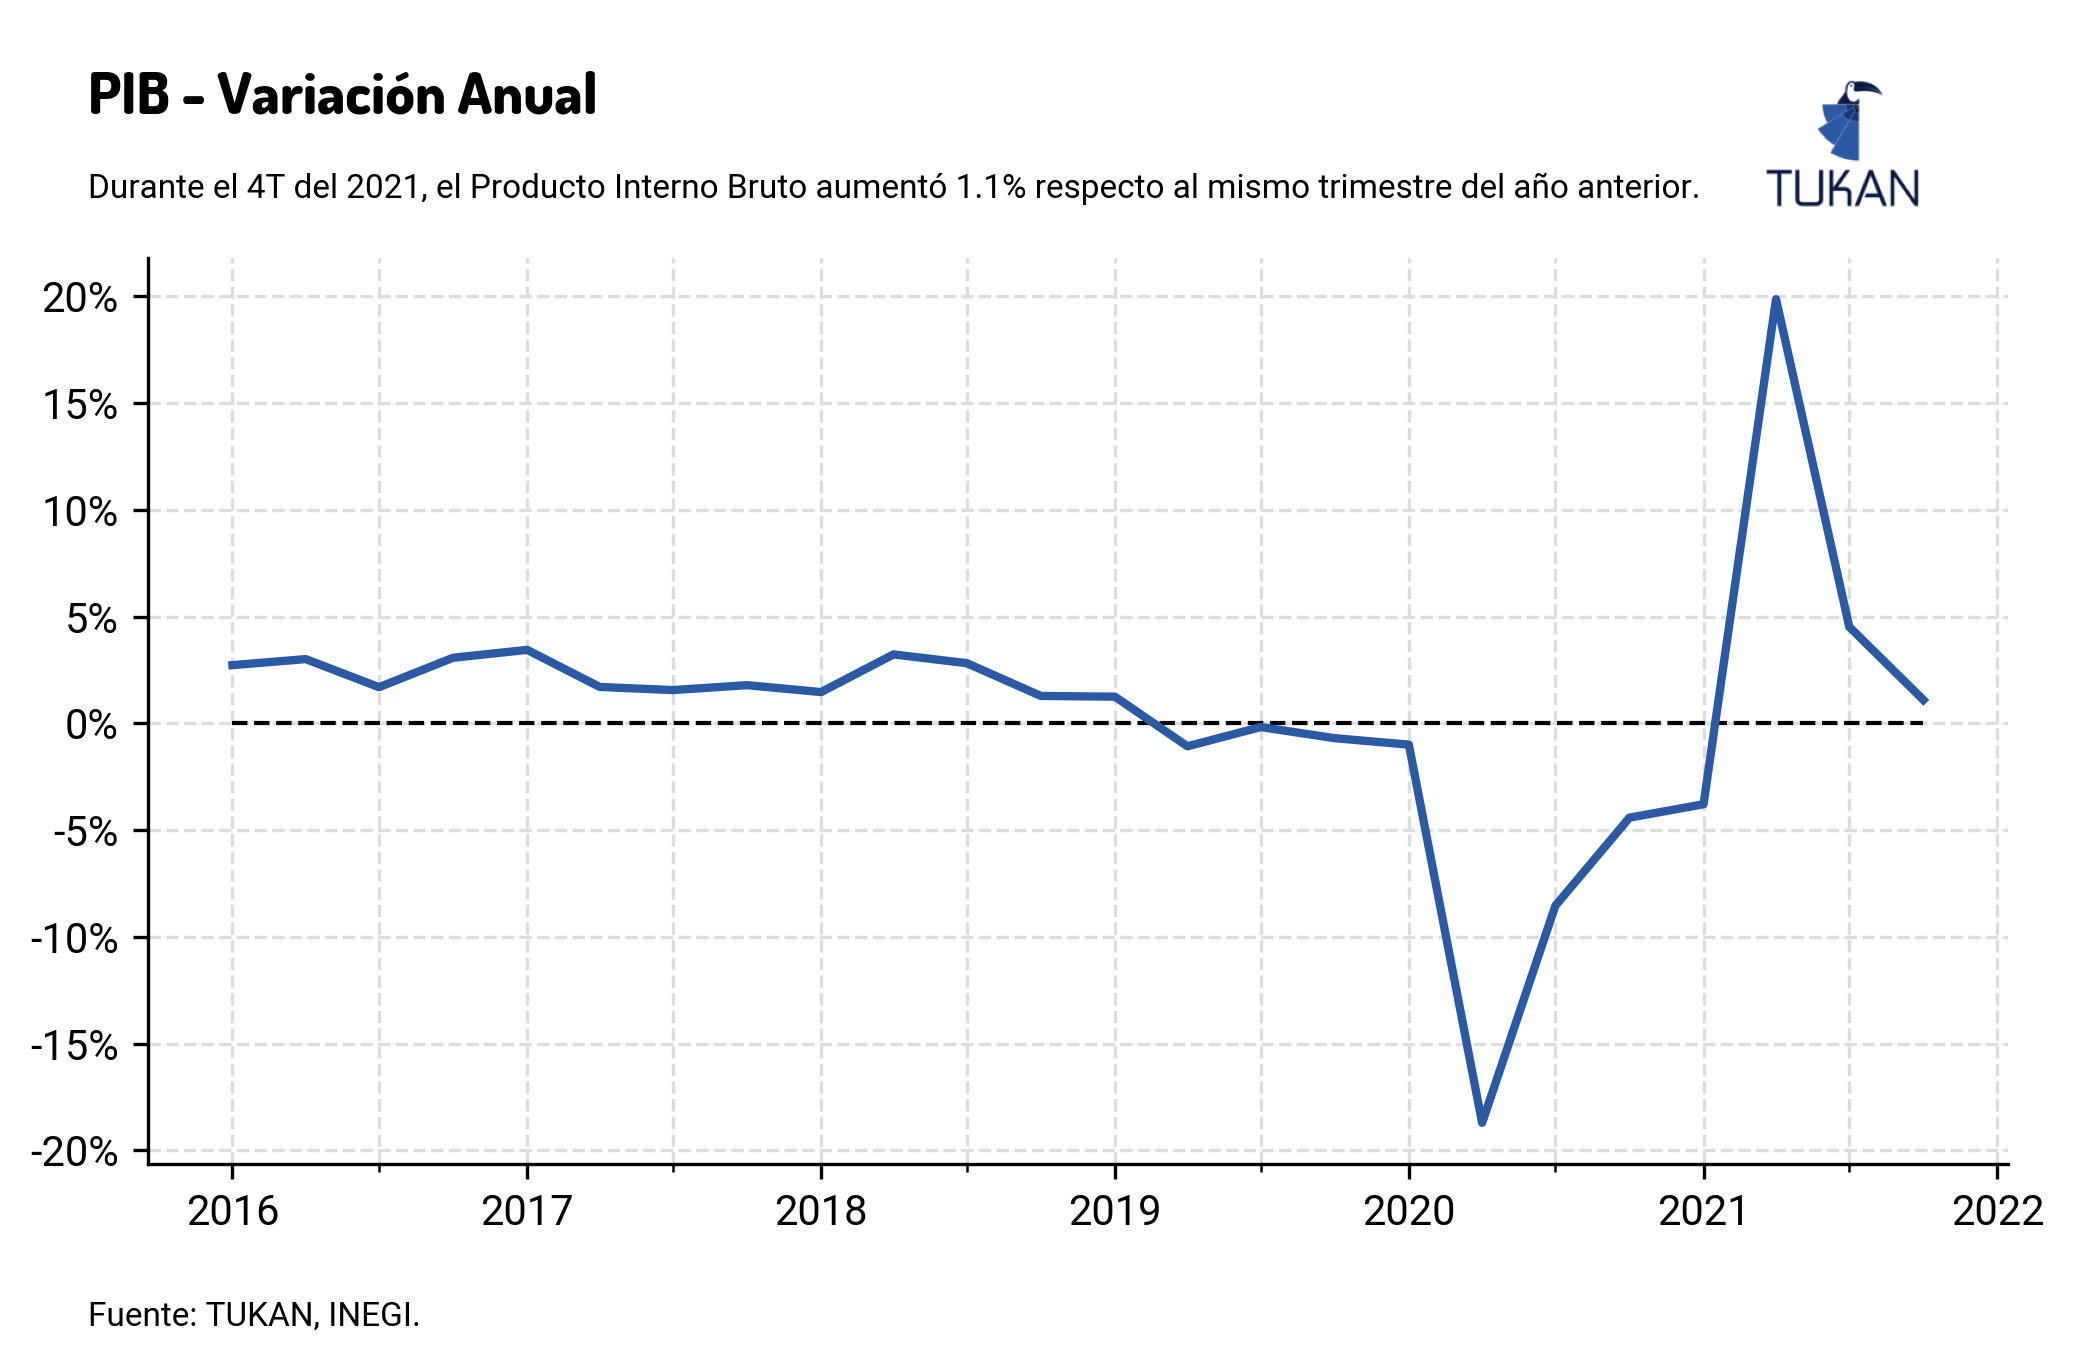

In [8]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

# Data to plot
ax.plot(filtered_gdp["date"], filtered_gdp["year_var"], lw=2, zorder=3)
ax.hlines(0, filtered_gdp["date"].min(), filtered_gdp["date"].max(), ls="--", color="black", lw=1)


# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(1))
ax.xaxis.set_minor_locator(mdates.MonthLocator(7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0%}'))

ax.grid(visible=True, which='minor', linestyle='--')

# Title and subtitle aux vars
last_quarter = filtered_gdp["date"].tail(1).dt.quarter.values[0]
last_year = filtered_gdp["date"].tail(1).dt.year.values[0]
growth = filtered_gdp["year_var"].iloc[-1]*100

if growth>0:
    variation = 'aumentó'
else:
    variation = 'disminuyó'

fig.text(
    0.1,
    1,
    "PIB - Variación Anual",
    size=14,
    weight = "bold",
    family = "Dosis"
)
fig.text(
    0.1,
    0.93,
    "Durante el "+ str(last_quarter) + "T del "+str(last_year)+ ", el Producto Interno Bruto " + variation + " " + str(growth.round(2)) +"% respecto al mismo trimestre del año anterior.",
    size=8
)
# Add footer
fig.text(0.1, -0.01, "Fuente: TUKAN, INEGI.", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/gdp_yoy_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/gdp_yoy_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True
)

plt.savefig(
    "plots/gdp_yoy_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

#### QoQ % Plot

(-0.5, 190.5, 190.5, -0.5)

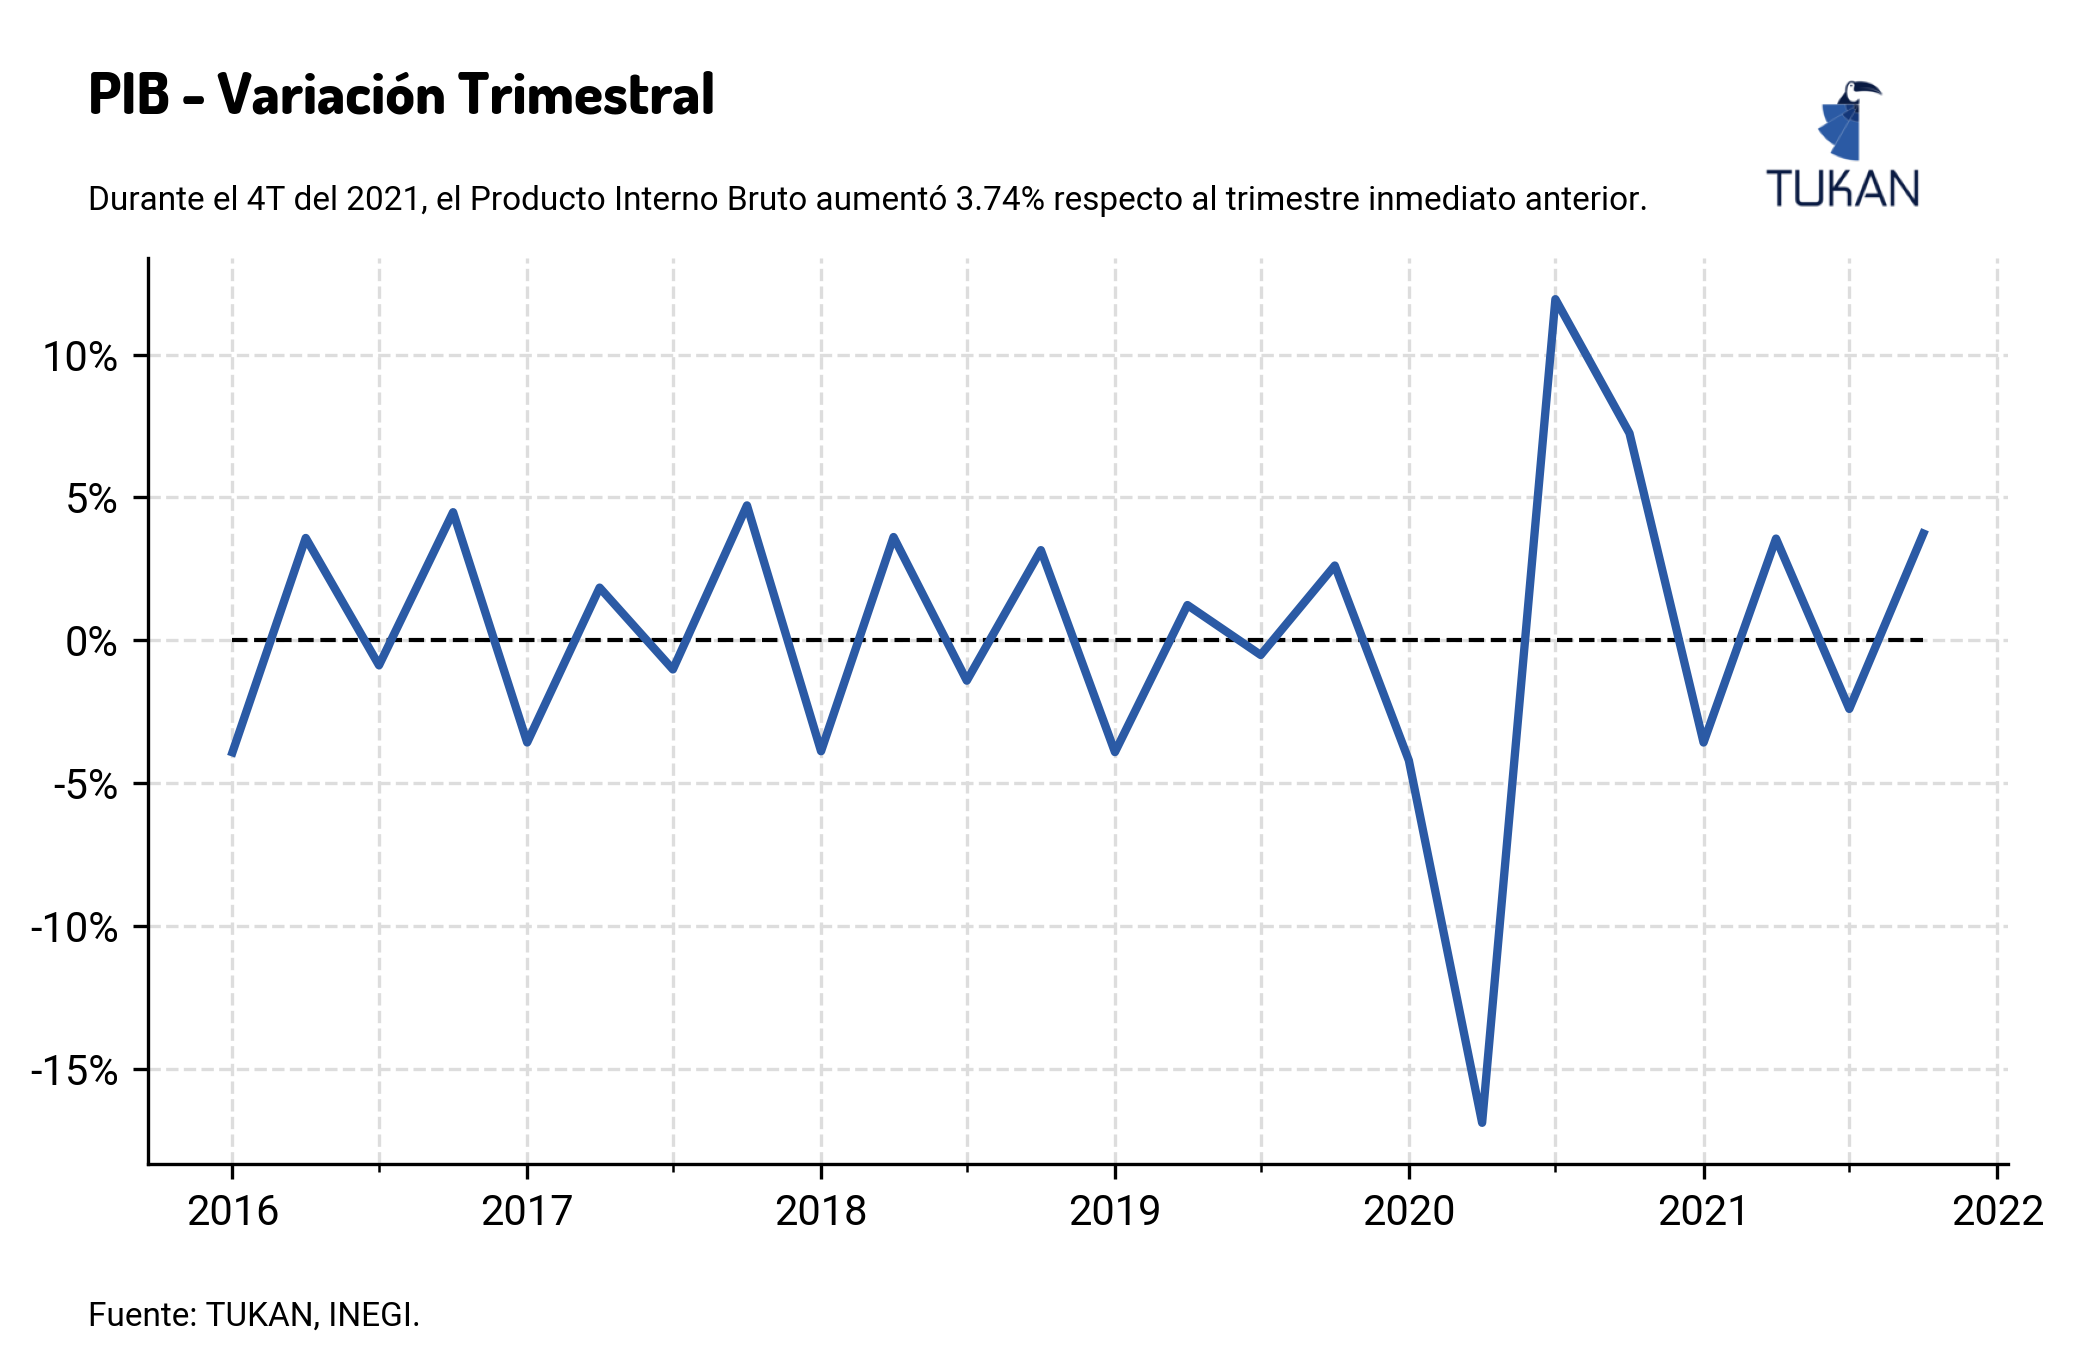

In [28]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

# Data to plot
ax.plot(filtered_gdp["date"], filtered_gdp["qrtr_var"], lw=2, zorder=3)
ax.hlines(0, filtered_gdp["date"].min(), filtered_gdp["date"].max(), ls="--", color="black", lw=1)

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(1))
ax.xaxis.set_minor_locator(mdates.MonthLocator(7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0%}'))

ax.grid(visible=True, which='minor', linestyle='--')

# Title and subtitle aux vars
last_quarter = filtered_gdp["date"].tail(1).dt.quarter.values[0]
last_year = filtered_gdp["date"].tail(1).dt.year.values[0]
growth = filtered_gdp["qrtr_var"].iloc[-1]*100

if growth>0:
    variation = 'aumentó'
else:
    variation = 'disminuyó'

fig.text(
    0.1,
    1,
    "PIB - Variación Trimestral",
    size=14,
    weight = "bold",
    family = "Dosis"
)
fig.text(
    0.1,
    0.92,
    "Durante el "+ str(last_quarter) + "T del "+str(last_year)+ ", el Producto Interno Bruto " + variation + " " + str(growth.round(2)) +"% respecto al trimestre inmediato anterior.",
    size=8
)
# Add footer
fig.text(0.1, -0.01, "Fuente: TUKAN, INEGI.", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/gdp_qoq_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

# plt.savefig(
#     "plots/gdp_qoq_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

# plt.savefig(
#     "plots/gdp_qoq_white_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="white",
#     edgecolor="none",
#     transparent=False,
# )

### Yearly

#### Filter

In [10]:
# Data
agg_filtered_gdp = gdp.copy()


# Units in billones (miles de millones)
agg_filtered_gdp['675882bced9ce54'] = agg_filtered_gdp['675882bced9ce54']/1000000000

# # Aggregated data
agg_filtered_gdp = agg_filtered_gdp.groupby([agg_filtered_gdp['date'].dt.year,'economic_activity__ref','economic_activity']).sum().reset_index()

# # Yearly variation
agg_filtered_gdp['year_var'] = agg_filtered_gdp.groupby(['economic_activity__ref'])['675882bced9ce54'].shift(1)
agg_filtered_gdp['year_var'] = (agg_filtered_gdp['675882bced9ce54']/agg_filtered_gdp['year_var'])-1

# # Date filters
# agg_filtered_gdp = agg_filtered_gdp[agg_filtered_gdp['date'] >=2000].reset_index(drop=True)
agg_filtered_gdp['date'] = pd.to_datetime(agg_filtered_gdp['date'].astype(str))


# # Filtered data
# agg_filtered_gdp.tail(5)
agg_filtered_gdp

,date,economic_activity__ref,economic_activity,675882bced9ce54,year_var
0,1999-01-01,dfeefc621d16d0c,Actividad económica,49295.288548,NaN
1,2000-01-01,dfeefc621d16d0c,Actividad económica,51731.685367,0.049425
2,2001-01-01,dfeefc621d16d0c,Actividad económica,51522.487540,-0.004044
3,2002-01-01,dfeefc621d16d0c,Actividad económica,51501.958672,-0.000398
4,2003-01-01,dfeefc621d16d0c,Actividad económica,52246.874084,0.014464
5,2004-01-01,dfeefc621d16d0c,Actividad económica,54295.260228,0.039206
6,2005-01-01,dfeefc621d16d0c,Actividad económica,55548.290080,0.023078
7,2006-01-01,dfeefc621d16d0c,Actividad económica,58045.228987,0.044951
8,2007-01-01,dfeefc621d16d0c,Actividad económica,59375.303901,0.022914
9,2008-01-01,dfeefc621d16d0c,Actividad económica,60054.310724,0.011436


#### Estimate

In [11]:
# Adding estimate
# eopib_yrtr_est = 0.05

# gdp_estimate = {'date':datetime(2022, 1, 1), 'economic_activity__ref': 'dfeefc621d16d0c', 'economic_activity': 'Actividad económica', '675882bced9ce54':float(agg_filtered_gdp['675882bced9ce54'].tail(1).values)*(1+eopib_yrtr_est),'year_var':eopib_yrtr_est}

# agg_filtered_gdp = agg_filtered_gdp.append(gdp_estimate, ignore_index = True)
# agg_filtered_gdp.tail(3)

#### Aggregate Plot


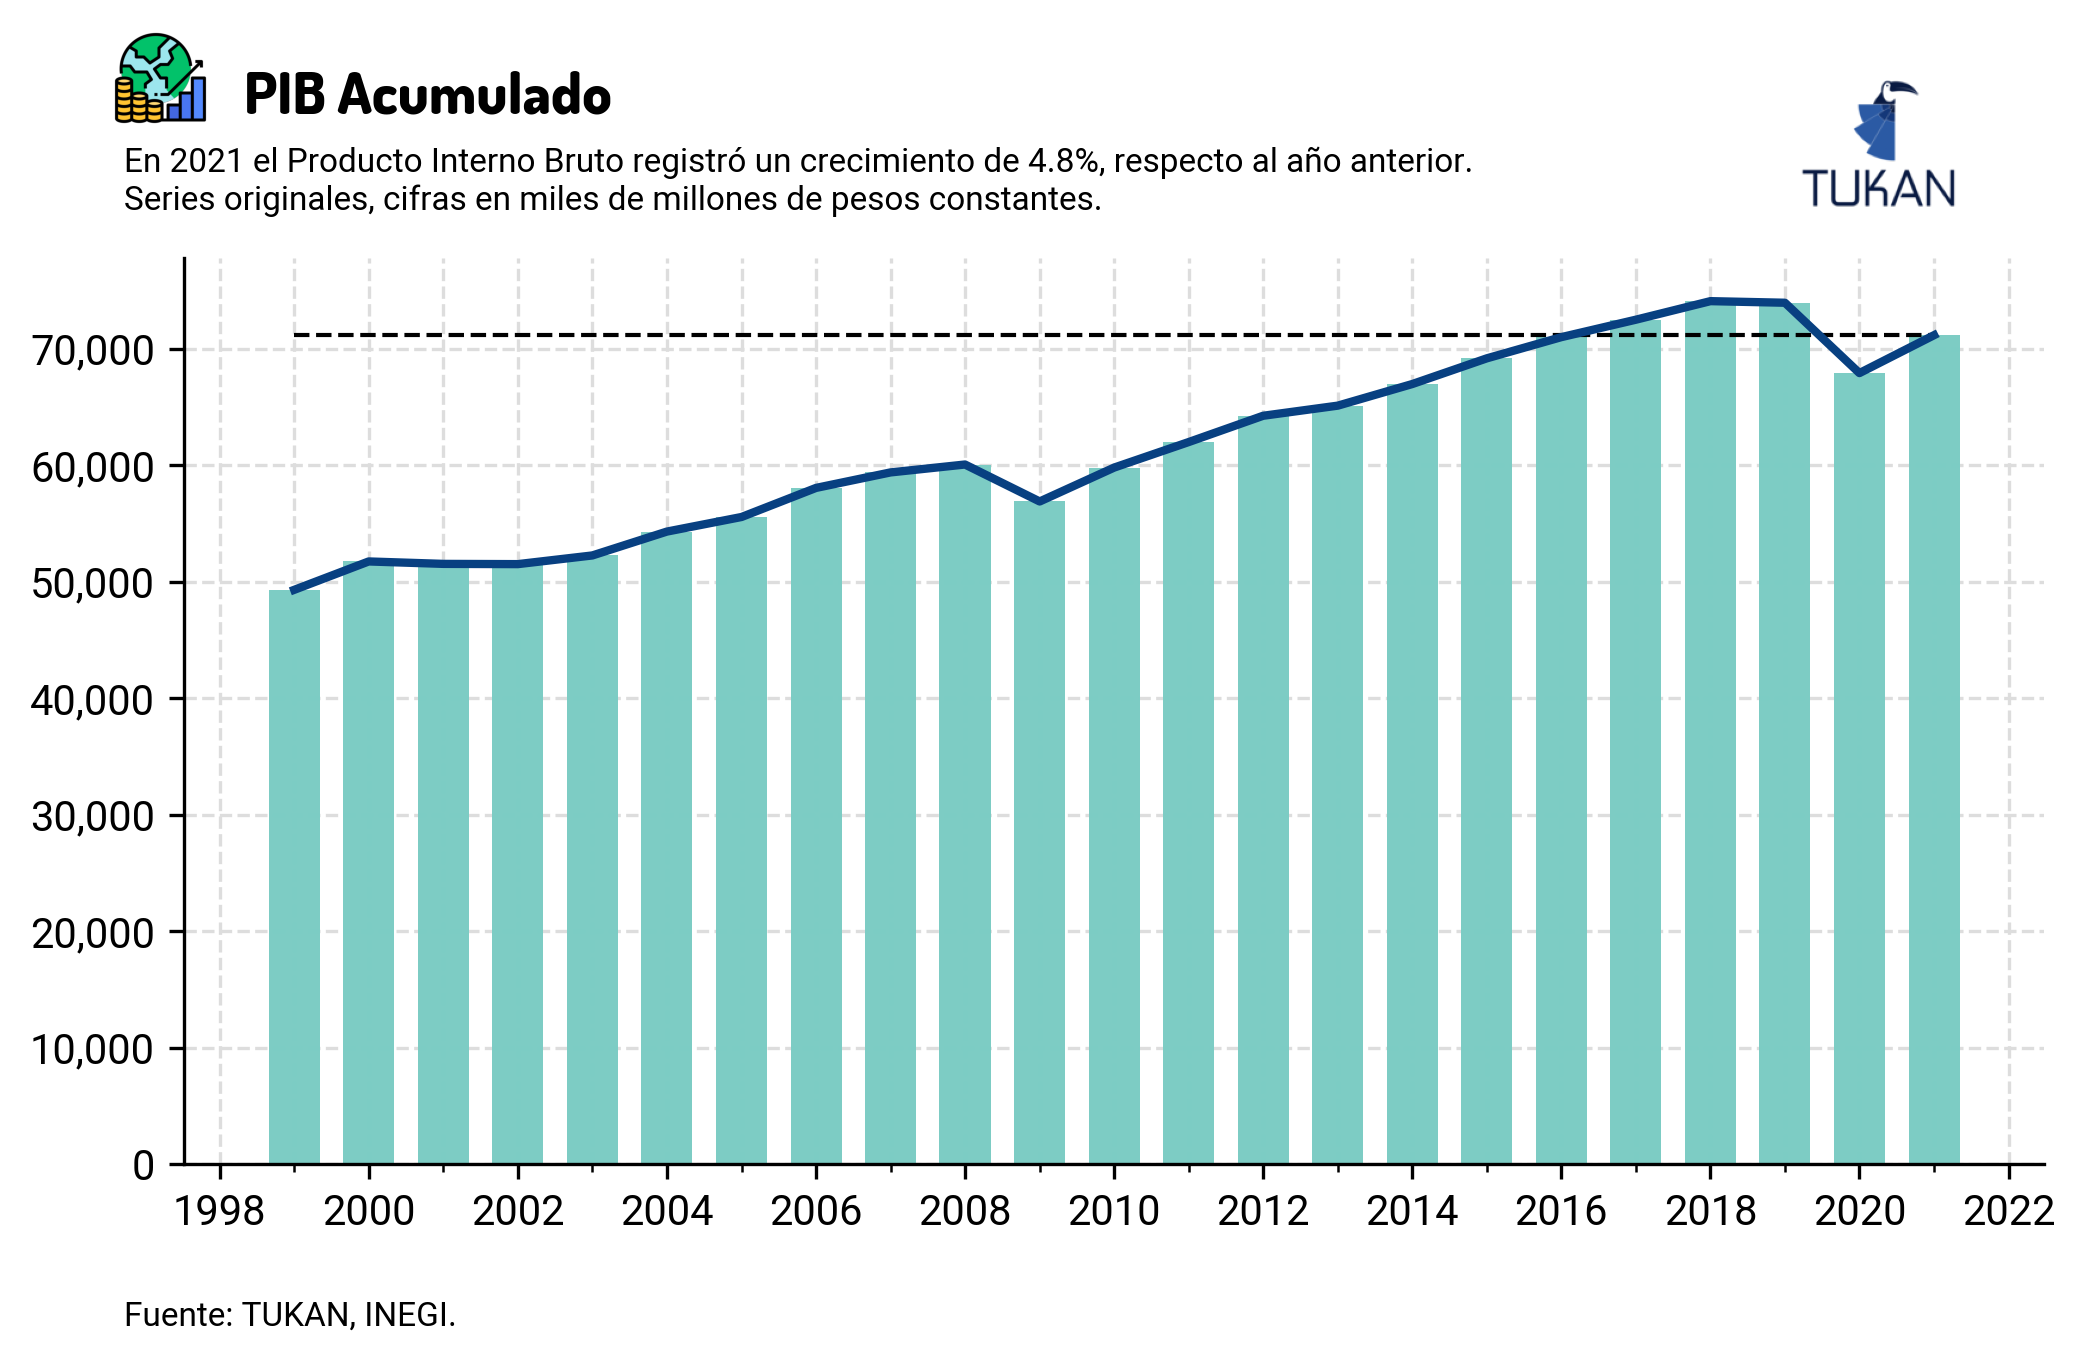

In [57]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)
cmap = mpl.cm.get_cmap("GnBu_r", 5)
# Data to plot
ax.plot(agg_filtered_gdp["date"], agg_filtered_gdp["675882bced9ce54"], lw=2, zorder=3, color=cmap(0))
ax.bar(agg_filtered_gdp["date"], agg_filtered_gdp["675882bced9ce54"], zorder=2, width = 250, align='center', alpha=0.99, color=cmap(2))
ax.hlines(agg_filtered_gdp["675882bced9ce54"].tail(1).values, agg_filtered_gdp["date"].min(), agg_filtered_gdp["date"].max(), ls="--", color="black", lw=1)

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(" ") 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.grid(visible=True, which='minor', linestyle='--')

ax.set_ylim(0)
# Title and subtitle aux vars
last_year = agg_filtered_gdp["date"].tail(1).dt.year.values[0]
growth = agg_filtered_gdp["year_var"].iloc[-1]*100

if growth>0:
    variation = 'un crecimiento'
else:
    variation = 'una disminución'

fig.text(
    0.15,
    1,
    "PIB Acumulado",
    size=14,
    weight = "bold",
    family = "Dosis"
)
fig.text(
    0.1,
    0.92,
    "En "+ str(last_year) + " el Producto Interno Bruto registró "+ variation + " de " + str(abs(growth.round(2))) +"%, respecto al año anterior.\nSeries originales, cifras en miles de millones de pesos constantes.",
    size=8
)
# Add footer
fig.text(0.1, -0.01, "Fuente: TUKAN, INEGI.", fontsize=8)

# Icon
econ_icon = image.imread("economic.png")
econ_ax = fig.add_axes([0.09, .99, 0.05, 0.08], zorder=1)
econ_ax.imshow(econ_icon)
econ_ax.axis("off")

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/gdp_agg_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/gdp_agg_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/gdp_agg_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

#### YoY % plot


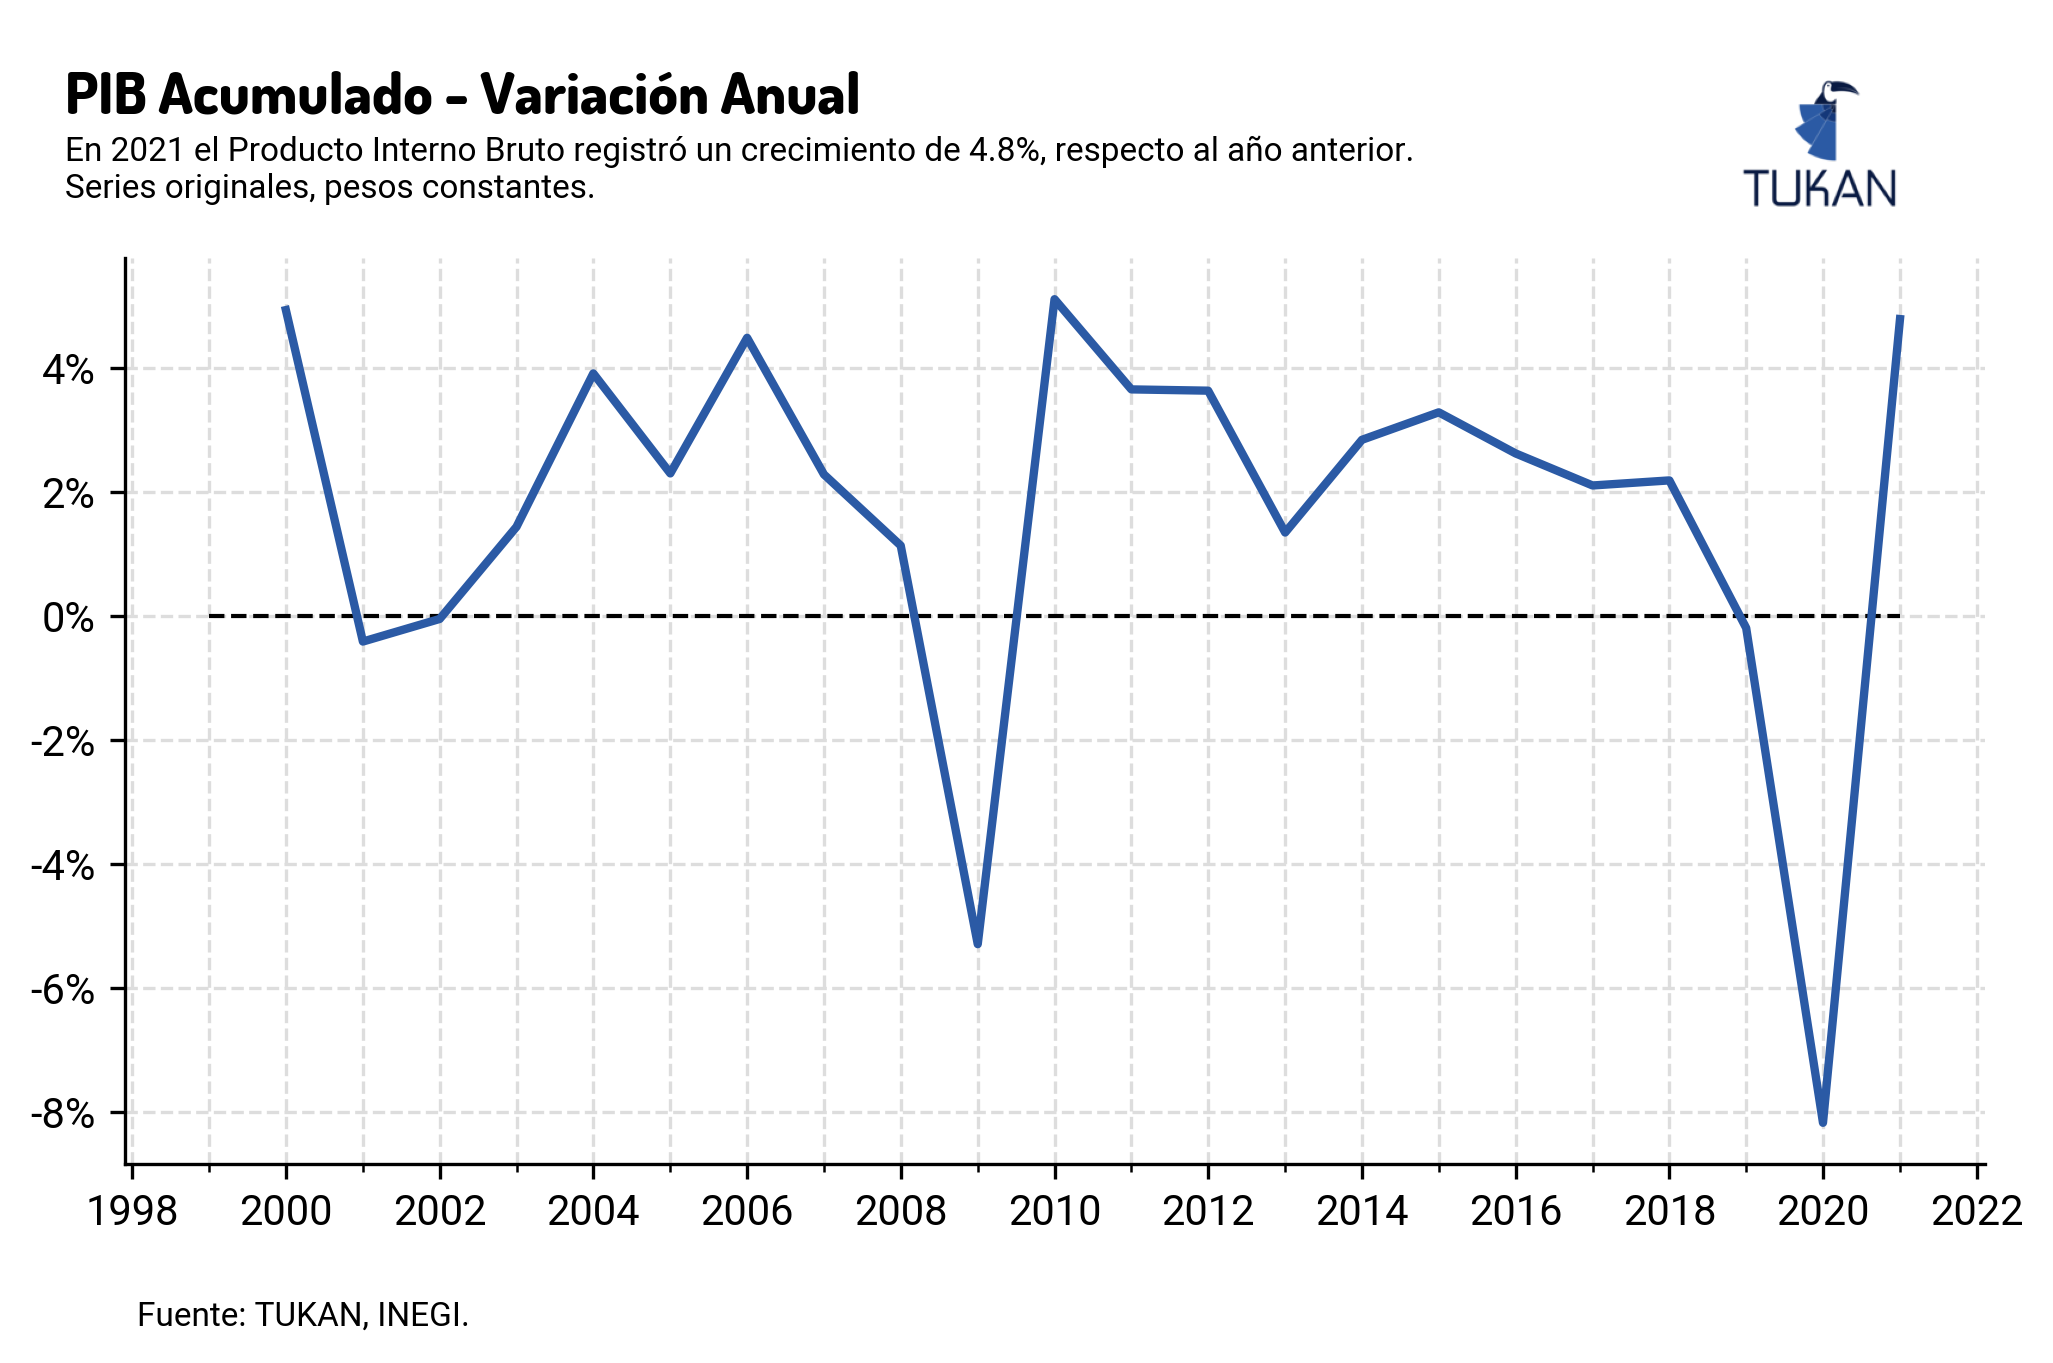

In [29]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

# Data to plot
ax.plot(agg_filtered_gdp["date"], agg_filtered_gdp["year_var"], lw=2, zorder=3)
ax.hlines(0, agg_filtered_gdp["date"].min(), agg_filtered_gdp["date"].max(), ls="--", color="black", lw=1)
# ax.bar(agg_filtered_gdp["date"], agg_filtered_gdp["year_var"], zorder=2, width = 250, align='center', alpha=0.9)

# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(" ") 

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0%}'))

ax.grid(visible=True, which='minor', linestyle='--')


# Title and subtitle aux vars
last_year = agg_filtered_gdp["date"].tail(1).dt.year.values[0]
growth = agg_filtered_gdp["year_var"].iloc[-1]*100

if growth>0:
    variation = 'un crecimiento'
else:
    variation = 'una disminución'

fig.text(
    0.1,
    1,
    "PIB Acumulado - Variación Anual",
    size=14,
    weight = "bold",
    family = "Dosis"
)
fig.text(
    0.1,
    0.93,
    "En "+ str(last_year) + " el Producto Interno Bruto registró "+ variation + " de " + str(abs(growth.round(2))) +"%, respecto al año anterior.\nSeries originales, pesos constantes.",
    size=8
)
# Add footer
fig.text(0.13, -0.01, "Fuente: TUKAN, INEGI.", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/gdp_agg_yoy_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/gdp_agg_yoy_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/gdp_agg_yoy_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

## (B) Economic Sectors

### Primary

#### Payload

In [14]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "economic_activity"
    ],
    "categories": {
        "economic_activity": [
            "7460634ca523beb"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_gdp_national",
            "variables": [
                "675882bced9ce54" #deflated
            ]
        }
    ],
    "from": "2001-01-01"
}

response = get_tukan_api_request(payload)
gdp_primary = response["data"]

Success getting the data


#### Filtering data

In [15]:
# Data
filtered_gdp_primary = gdp_primary.copy()

# Units in millions
filtered_gdp_primary['675882bced9ce54'] = filtered_gdp_primary['675882bced9ce54']/1000000

# Quarterly variation
filtered_gdp_primary['qrtr_var'] = filtered_gdp_primary.groupby(['economic_activity__ref'])['675882bced9ce54'].shift()
filtered_gdp_primary['qrtr_var'] = (filtered_gdp_primary['675882bced9ce54']/filtered_gdp_primary['qrtr_var'])-1

# Yearly variation
filtered_gdp_primary['year_var'] = filtered_gdp_primary.groupby(['economic_activity__ref'])['675882bced9ce54'].shift(4)
filtered_gdp_primary['year_var'] = (filtered_gdp_primary['675882bced9ce54']/filtered_gdp_primary['year_var'])-1

# Date filters
first_date = '2021-01-01'
second_date = last_date(filtered_gdp_primary)
filtered_gdp_primary = date_selection(filtered_gdp_primary,first_date,second_date, True)

# Filtered data
filtered_gdp_primary.tail(3)

,date,economic_activity__ref,economic_activity,675882bced9ce54,qrtr_var,year_var
1,2021-04-01,7460634ca523beb,Actividades primarias,626964.543,0.113637,0.063639
2,2021-07-01,7460634ca523beb,Actividades primarias,520333.901,-0.170074,0.006533
3,2021-10-01,7460634ca523beb,Actividades primarias,734723.670,0.412023,0.047090


#### Estimate

In [16]:
# Adding estimate
# eopib_qrtr_est = 0.003
# eopib_yrtr_est = .027

# gdp_estimate = {'date': datetime(2021, 10, 1), 'economic_activity__ref': '7460634ca523beb', 'economic_activity': 'Actividades primarias', '675882bced9ce54':float(filtered_gdp_primary['675882bced9ce54'].tail(1).values)*(1+eopib_qrtr_est),'qrtr_var':eopib_qrtr_est,'year_var':eopib_yrtr_est}

# filtered_gdp_primary = filtered_gdp_primary.append(gdp_estimate, ignore_index = True)
# filtered_gdp_primary.tail(3)

### Secondary

#### Payload

In [17]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "economic_activity"
    ],
    "categories": {
        "economic_activity": [
            "761bc00426e1c48"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_gdp_national",
            "variables": [
                "675882bced9ce54" #deflated
            ]
        }
    ],
    "from": "2001-01-01"
}

response = get_tukan_api_request(payload)
gdp_secondary = response["data"]

Success getting the data


#### Filtering data

In [18]:
# Data
filtered_gdp_secondary = gdp_secondary.copy()

# Units in millions
filtered_gdp_secondary['675882bced9ce54'] = filtered_gdp_secondary['675882bced9ce54']/1000000

# Quarterly variation
filtered_gdp_secondary['qrtr_var'] = filtered_gdp_secondary.groupby(['economic_activity__ref'])['675882bced9ce54'].shift()
filtered_gdp_secondary['qrtr_var'] = (filtered_gdp_secondary['675882bced9ce54']/filtered_gdp_secondary['qrtr_var'])-1

# Yearly variation
filtered_gdp_secondary['year_var'] = filtered_gdp_secondary.groupby(['economic_activity__ref'])['675882bced9ce54'].shift(4)
filtered_gdp_secondary['year_var'] = (filtered_gdp_secondary['675882bced9ce54']/filtered_gdp_secondary['year_var'])-1

# Date filters
first_date = '2021-01-01'
second_date = last_date(filtered_gdp_secondary)
filtered_gdp_secondary = date_selection(filtered_gdp_secondary,first_date,second_date, True)

# Filtered data
filtered_gdp_secondary.tail(3)

,date,economic_activity__ref,economic_activity,675882bced9ce54,qrtr_var,year_var
1,2021-04-01,761bc00426e1c48,Actividades secundarias,5088146.572,0.003167,0.274880
2,2021-07-01,761bc00426e1c48,Actividades secundarias,5133949.335,0.009002,0.049556
3,2021-10-01,761bc00426e1c48,Actividades secundarias,5106975.237,-0.005254,0.017496


#### Estimate

In [19]:
# Adding estimate
# eopib_qrtr_est = 0.004
# eopib_yrtr_est = 0.068

# gdp_estimate = {'date': datetime(2021, 10, 1), 'economic_activity__ref': '7460634ca523beb', 'economic_activity': 'Actividades secundarias', '675882bced9ce54':float(filtered_gdp_secondary['675882bced9ce54'].tail(1).values)*(1+eopib_qrtr_est),'qrtr_var':eopib_qrtr_est,'year_var':eopib_yrtr_est}

# filtered_gdp_secondary = filtered_gdp_secondary.append(gdp_estimate, ignore_index = True)
# filtered_gdp_secondary['qrtr_var'] =filtered_gdp_secondary['qrtr_var']*100
# filtered_gdp_secondary.tail(3)

### Terciary

#### Payload

In [20]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "economic_activity"
    ],
    "categories": {
        "economic_activity": [
            "8fd5b02b9f891fb"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_gdp_national",
            "variables": [
                "675882bced9ce54" #deflated
            ]
        }
    ],
    "from": "2001-01-01"
}

response = get_tukan_api_request(payload)
gdp_terciary = response["data"]

Success getting the data


#### Filtering data

In [21]:
# Data
filtered_gdp_terciary = gdp_terciary.copy()

# Units in millions
filtered_gdp_terciary['675882bced9ce54'] = filtered_gdp_terciary['675882bced9ce54']/1000000

# Quarterly variation
filtered_gdp_terciary['qrtr_var'] = filtered_gdp_terciary.groupby(['economic_activity__ref'])['675882bced9ce54'].shift()
filtered_gdp_terciary['qrtr_var'] = (filtered_gdp_terciary['675882bced9ce54']/filtered_gdp_terciary['qrtr_var'])-1

# Yearly variation
filtered_gdp_terciary['year_var'] = filtered_gdp_terciary.groupby(['economic_activity__ref'])['675882bced9ce54'].shift(4)
filtered_gdp_terciary['year_var'] = (filtered_gdp_terciary['675882bced9ce54']/filtered_gdp_terciary['year_var'])-1

# Date filters
first_date = '2021-01-01'
second_date = last_date(filtered_gdp_terciary)
filtered_gdp_terciary = date_selection(filtered_gdp_terciary,first_date,second_date, True)

# Filtered data
filtered_gdp_terciary.tail(3)

,date,economic_activity__ref,economic_activity,675882bced9ce54,qrtr_var,year_var
1,2021-04-01,8fd5b02b9f891fb,Actividades terciarias,1.155083e+07,0.046046,0.176659
2,2021-07-01,8fd5b02b9f891fb,Actividades terciarias,1.114612e+07,-0.035037,0.041990
3,2021-10-01,8fd5b02b9f891fb,Actividades terciarias,1.156952e+07,0.037986,0.002044


#### Estimate

In [22]:
# Adding estimate
# eopib_qrtr_est = -0.007
# eopib_yrtr_est = 0.042

# gdp_estimate = {'date': datetime(2021, 10, 1), 'economic_activity__ref': '8fd5b02b9f891fb', 'economic_activity': 'Actividades terciarias', '675882bced9ce54':float(filtered_gdp_terciary['675882bced9ce54'].tail(1).values)*(1+eopib_qrtr_est),'qrtr_var':eopib_qrtr_est,'year_var':eopib_yrtr_est}

# filtered_gdp_terciary = filtered_gdp_terciary.append(gdp_estimate, ignore_index = True)
# filtered_gdp_terciary.tail(3)

## (C) Ecnonomic Activities

### Payload

In [23]:
# Main payload
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "economic_activity"
    ],
    "categories": {
        "economic_activity": [
            "6b36ca46b6cfd91",
            "457155464609a2f",
            "36348912d8470dd",
            "faa2a8d0af8a72c",
            "be676b5dd921cb7",
            "f5adaadda584ca7",
            "e426cc87d0540ab",
            "afcc312ccddfcc1",
            "990b94ebe38c9ca",
            "d35f5b82779e7d5",
            "3726993cc9fecab",
            "bbb49ae78601ab9",
            "4bc9836c2d7e60a",
            "fcb303b72a98f6c",
            "d05c3b2b73d75fc",
            "44d246411040129",
            "a07267f78158c2c",
            "feb7bb4445c808d",
            "169c33ccdd66d77",
            "23cf92d98dd7c11"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_gdp_national",
            "variables": [
                "675882bced9ce54"
            ]
        }
    ],
    "from": "2000-01-01"
}

response = get_tukan_api_request(payload)

Success getting the data


### Cumulative GDP

In [24]:
# Data
activities_gdp = response["data"]

# Remove the quarters from previous years that are not available yet for the current year
date_filter = activities_gdp['date'].max().month
activities_gdp = activities_gdp[activities_gdp["date"].dt.month<= date_filter]

# Calculate the cumulative GDP for each year and economic activity, dividing it by a million 
activities_gdp = activities_gdp.groupby([activities_gdp.date.dt.year,'economic_activity__ref','economic_activity']).sum().reset_index()
activities_gdp['675882bced9ce54'] = activities_gdp['675882bced9ce54']/1000000

# Pivot the data frame so it is easy to plot, calculate the variation between 2021-2019 and 2021-2020, sort ascendingly according to it
activities_gdp = activities_gdp.pivot(index = 'economic_activity', columns='date', values='675882bced9ce54').reset_index()
activities_gdp['var_2021_2019'] =  (activities_gdp[2021] / activities_gdp[2019])-1
activities_gdp['var_2021_2020'] =  (activities_gdp[2021] / activities_gdp[2020])-1
activities_gdp['var_2020_2019'] =  (activities_gdp[2020] / activities_gdp[2019])-1

# Rename the tickers to improve plot design
activities_gdp = activities_gdp.replace({'Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos':'Serv. de esparcimiento y recreativos',
                   'Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final':'Energía, suministro de agua y gas natural',
                   'Servicios de alojamiento temporal y de preparación de alimentos y bebidas':'Hoteles y Restaurantes',
                   'Otros servicios excepto actividades gubernamentales':'Otros servicios',
                   'Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza':'Agricultura, ganadería, pesca y acts. forestales',
                   'Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación':'Serv. de apoyo a los negocios y manejo de residuos',
                   'Actividades legislativas, gubernamentales, de impartición de justicia y de organismos internacionales y extraterritoriales':'Acts. gubernamentales y legislativas',
                   'Servicios inmobiliarios y de alquiler de bienes muebles e intangibles':'Serv. inmobiliarios y alquiler de bienes',
                   'Servicios de salud y de asistencia social':'Serv. sociales y de salud',
                   'Servicios profesionales, científicos y técnicos':'Serv. profesionales, científicos y técnicos',
                   'Servicios educativos':'Serv. educativos',
                   'Servicios financieros y de seguros':
                   'Serv. financieros y de seguros'
 })

### 2021 vs 2020 plot

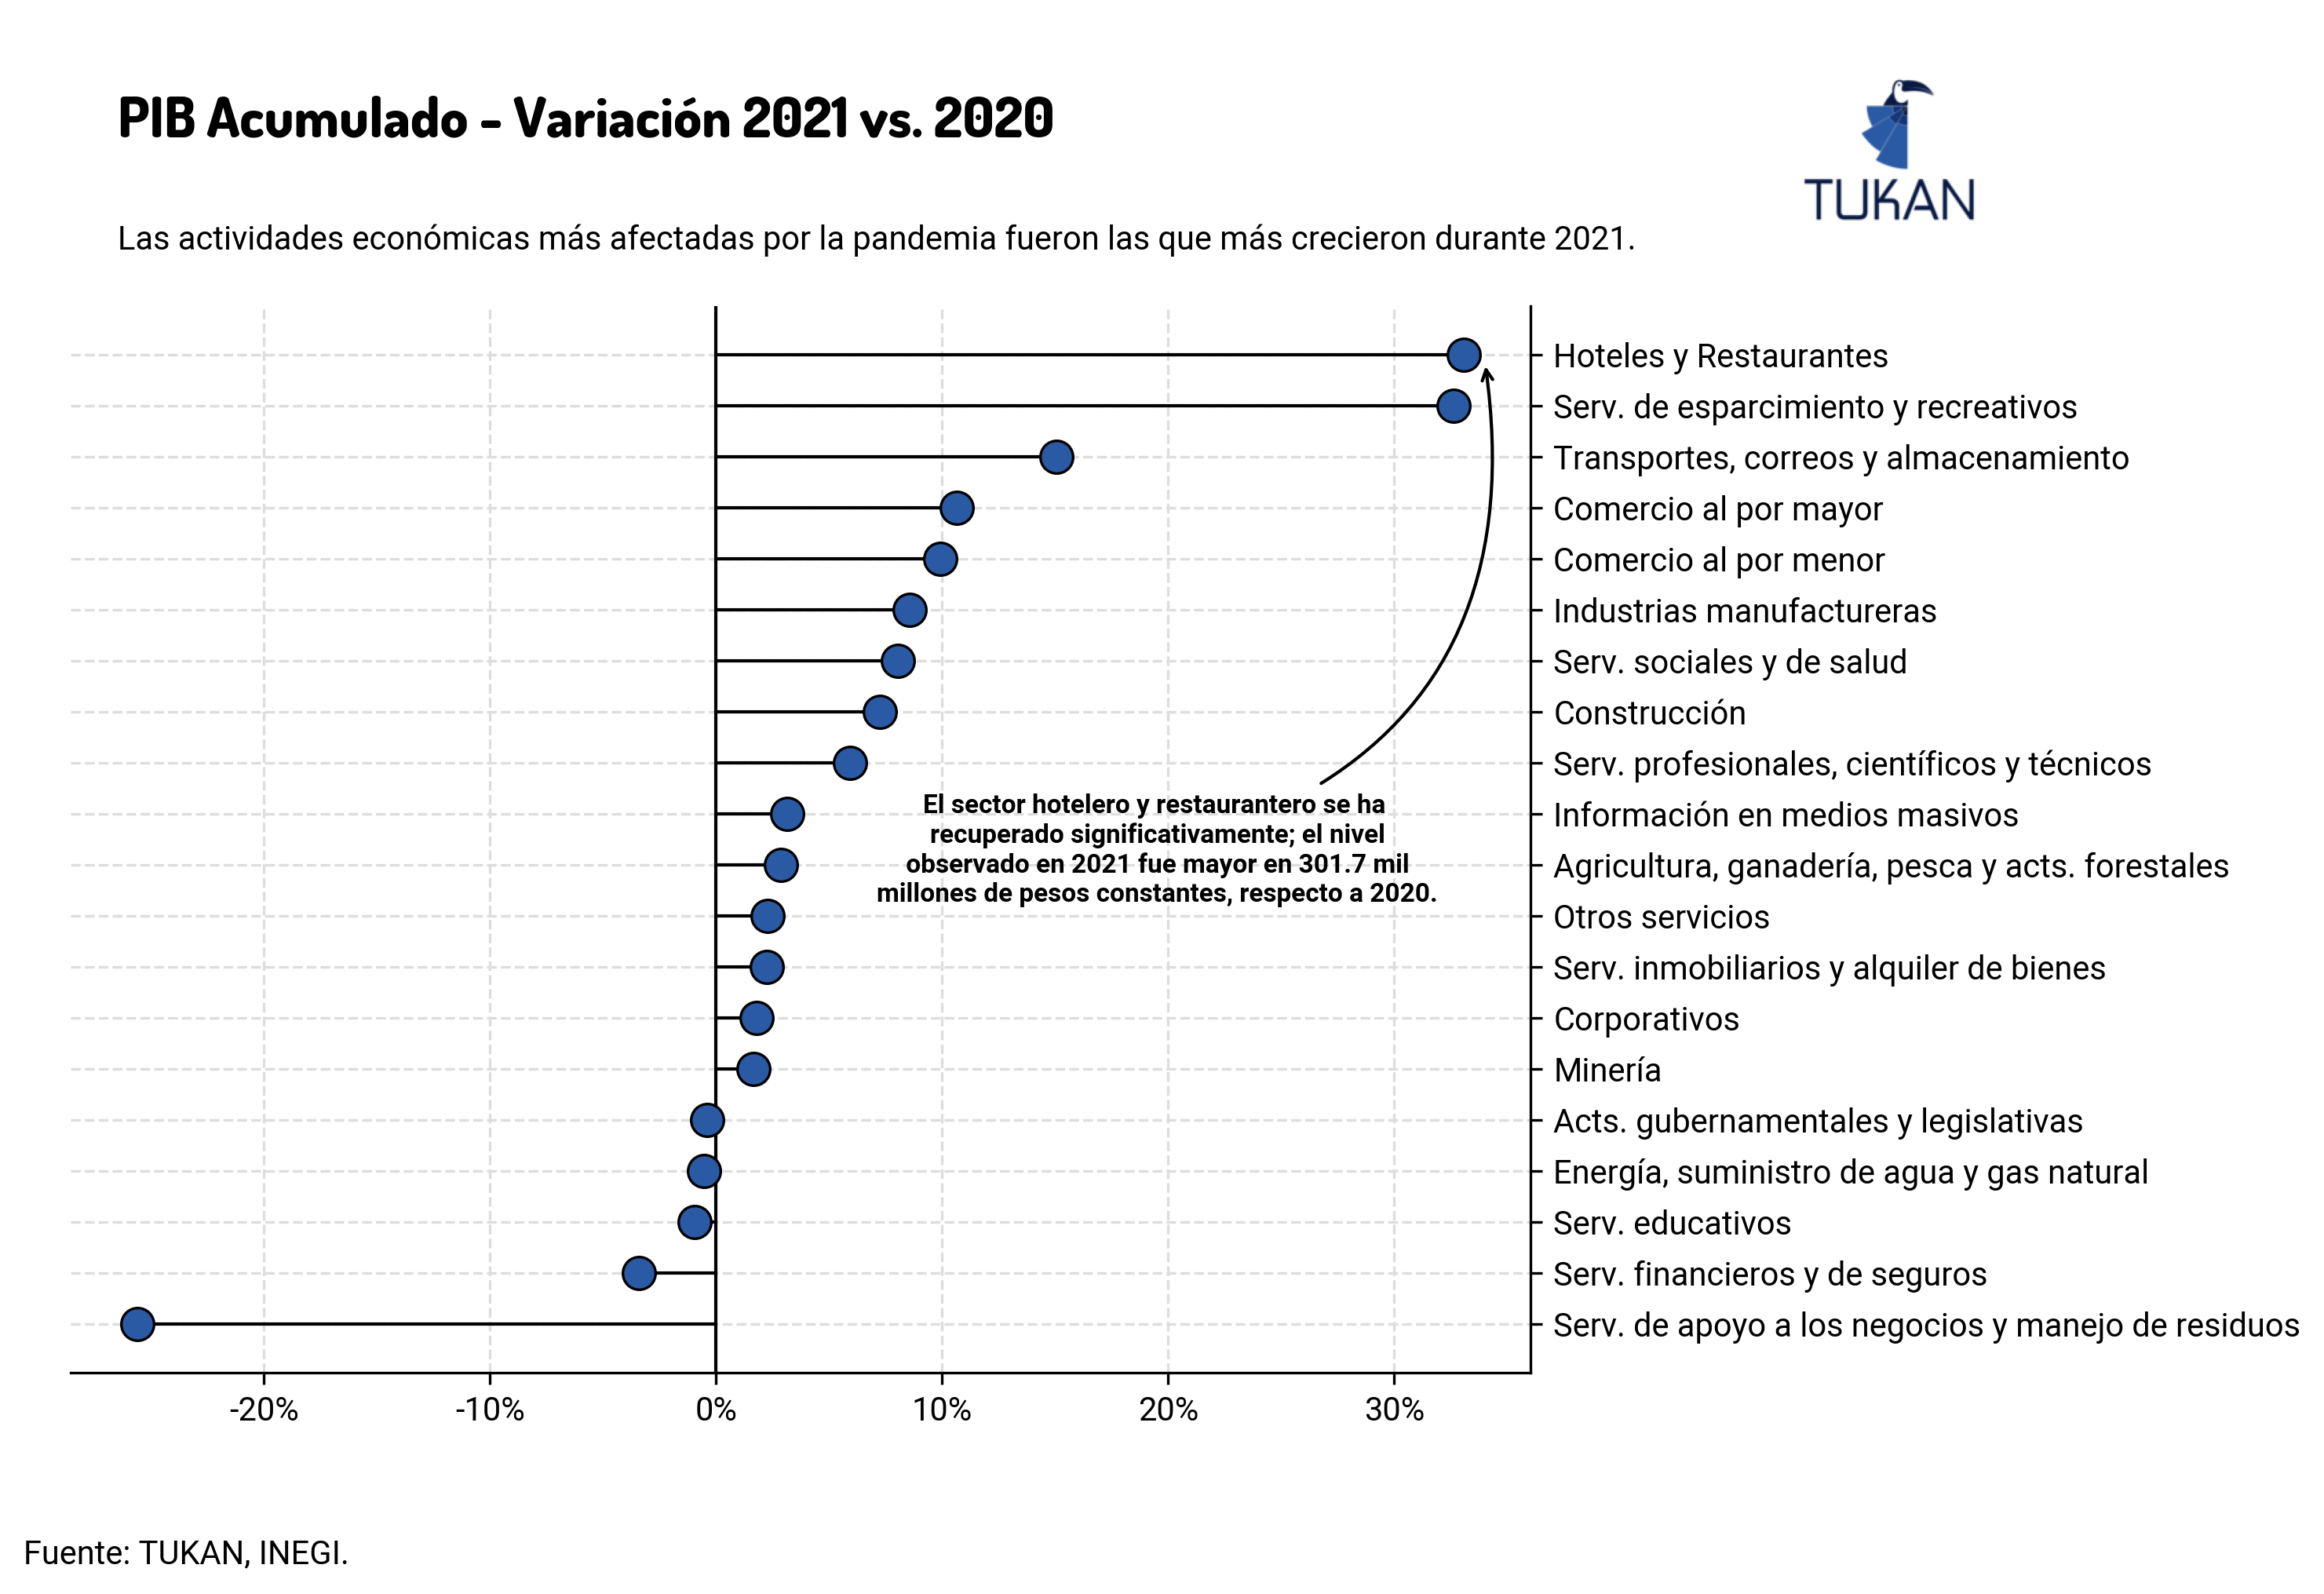

In [44]:

activities_gdp = activities_gdp.sort_values('var_2021_2020', ascending=True)
activities_gdp['p_ref'] =  range(activities_gdp.shape[0]) #plot_reference
activities_gdp.reset_index(drop=True, inplace=True)

text_annotation = activities_gdp[activities_gdp['economic_activity']=='Hoteles y Restaurantes']
text_annotation = (text_annotation[2021] - text_annotation[2020])/1000
text_annotation = text_annotation.round(1)

labels = activities_gdp['economic_activity'].tolist()

fig = plt.figure(figsize=(8,6), dpi = 300)
ax = plt.subplot(111)

# Change splines
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(False)

# Data to plot
for x in activities_gdp.index:
    if activities_gdp['var_2021_2020'].loc[x]>=0:
        ax.hlines(y=activities_gdp['p_ref'].loc[x], xmin=0, xmax=activities_gdp['var_2021_2020'].loc[x],lw=1, color='black' ,zorder=2)
    else:
        ax.hlines(y=activities_gdp['p_ref'].loc[x], xmin=activities_gdp['var_2021_2020'].loc[x], xmax=0,lw=1, color='black' ,zorder=2)
        
ax.scatter(activities_gdp['var_2021_2020'],activities_gdp['p_ref'],s=100, edgecolors='black', lw=0.8, zorder=3, label='2021')



# Add gridlines and format to ticks 
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0%}'))
ax.axvline(x=0,lw=1, color='black')
ax.set_yticks(range(activities_gdp.shape[0]))
ax.set_yticklabels(labels)

# Axis ticks on right side
ax.yaxis.tick_right()

# Annotation aux
text_annotation = activities_gdp[activities_gdp['economic_activity']=='Hoteles y Restaurantes']
text_annotation = (text_annotation[2021] - text_annotation[2020])/1000
text_annotation = text_annotation.round(1)

ax.annotate(
    "El sector hotelero y restaurantero se ha \nrecuperado significativamente; el nivel\n observado en 2021 fue mayor en "+ str(text_annotation.iloc[0])+ " mil \nmillones de pesos constantes, respecto a 2020.",
    xy=(.34,
        18.9),
    xycoords="data",
    xytext=(-100, -150),
    textcoords="offset points",
    color="black",
    size=8,
    va="center",
    ha="center",
    weight="bold",
    arrowprops=dict(
        arrowstyle="->", ec="black", connectionstyle="arc3,rad=.45"
    ),
)

# Add title and subtitle
fig.text(
    0.15,
    1,
    "PIB Acumulado - Variación 2021 vs. 2020",
    size=17,
    weight = "bold",
    family = "Dosis"
)

fig.text(
    0.15,
    0.92,
    "Las actividades económicas más afectadas por la pandemia fueron las que más crecieron durante 2021.",
    size=10
)

# Add footer
fig.text(0.1, -0.01, "Fuente: TUKAN, INEGI.", fontsize=10)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/gdp_activities_yoy_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

#Tukey's Swag
tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([1, .9, 0.16, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/gdp_activities_yoy_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/gdp_activities_yoy_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

In [41]:
activities_gdp

date,economic_activity,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2016,2017,2018,2019,2020,2021,var_2021_2019,var_2021_2020,var_2020_2019,p_ref
0,Serv. de apoyo a los negocios y manejo de resi...,1837103.109,1809243.468,1813389.313,1808637.012,1872732.780,1937718.036,2008938.604,2069502.771,2114020.188,...,2.354291e+06,2.543370e+06,2.658904e+06,2.782258e+06,2.811266e+06,2.090924e+06,-0.248480,-0.256234,0.010426,0
1,Serv. financieros y de seguros,636330.080,670207.572,715307.735,746212.808,902063.964,845593.285,942414.045,1023648.096,1274017.611,...,3.175490e+06,3.361046e+06,3.527572e+06,3.602462e+06,3.405065e+06,3.289002e+06,-0.087013,-0.034085,-0.054795,1
2,Serv. educativos,2284344.307,2326516.208,2363539.533,2402944.097,2433871.876,2479947.580,2478885.732,2524524.825,2554634.921,...,2.694147e+06,2.725648e+06,2.739549e+06,2.751481e+06,2.689448e+06,2.663497e+06,-0.031977,-0.009649,-0.022545,2
3,"Energía, suministro de agua y gas natural",540521.943,568614.512,566716.803,587993.568,655015.972,710089.168,793166.960,840882.263,846929.028,...,1.074617e+06,1.070217e+06,1.150902e+06,1.143824e+06,1.077339e+06,1.071729e+06,-0.063030,-0.005207,-0.058125,3
4,Acts. gubernamentales y legislativas,2419624.536,2271800.793,2301079.132,2292422.523,2288685.224,2304656.107,2350709.687,2370248.856,2422972.552,...,2.803684e+06,2.809798e+06,2.903345e+06,2.839885e+06,2.857951e+06,2.846407e+06,0.002297,-0.004039,0.006362,4
5,Minería,4732091.963,4871060.255,4898498.177,5136496.948,5219022.772,5230605.948,5155477.016,5026307.344,4766010.940,...,4.139250e+06,3.796037e+06,3.588167e+06,3.430268e+06,3.405181e+06,3.460980e+06,0.008953,0.016387,-0.007313,5
6,Corporativos,227427.353,222522.483,224459.252,253136.631,259410.204,268650.295,306926.943,309842.109,333930.207,...,4.074921e+05,4.131746e+05,4.387277e+05,4.340994e+05,4.644903e+05,4.728373e+05,0.089238,0.017970,0.070009,6
7,Serv. inmobiliarios y alquiler de bienes,5133416.400,5326919.616,5449423.692,5655383.275,5860810.332,6000356.435,6252030.172,6464873.719,6679844.784,...,7.913940e+06,8.017208e+06,8.153759e+06,8.256103e+06,8.231913e+06,8.416272e+06,0.019400,0.022396,-0.002930,7
8,Otros servicios,1079445.340,1091667.981,1103369.557,1110012.293,1138370.824,1172924.797,1211828.048,1255382.916,1270979.556,...,1.446560e+06,1.440661e+06,1.451579e+06,1.471319e+06,1.234161e+06,1.262276e+06,-0.142078,0.022781,-0.161187,8
9,"Agricultura, ganadería, pesca y acts. forestales",1643837.759,1731823.687,1716124.204,1781872.141,1823882.648,1757394.736,1867743.579,1946728.900,1945859.856,...,2.240241e+06,2.315850e+06,2.376162e+06,2.369293e+06,2.376559e+06,2.445011e+06,0.031958,0.028803,0.003067,9


### 2021 vs 2019 plot

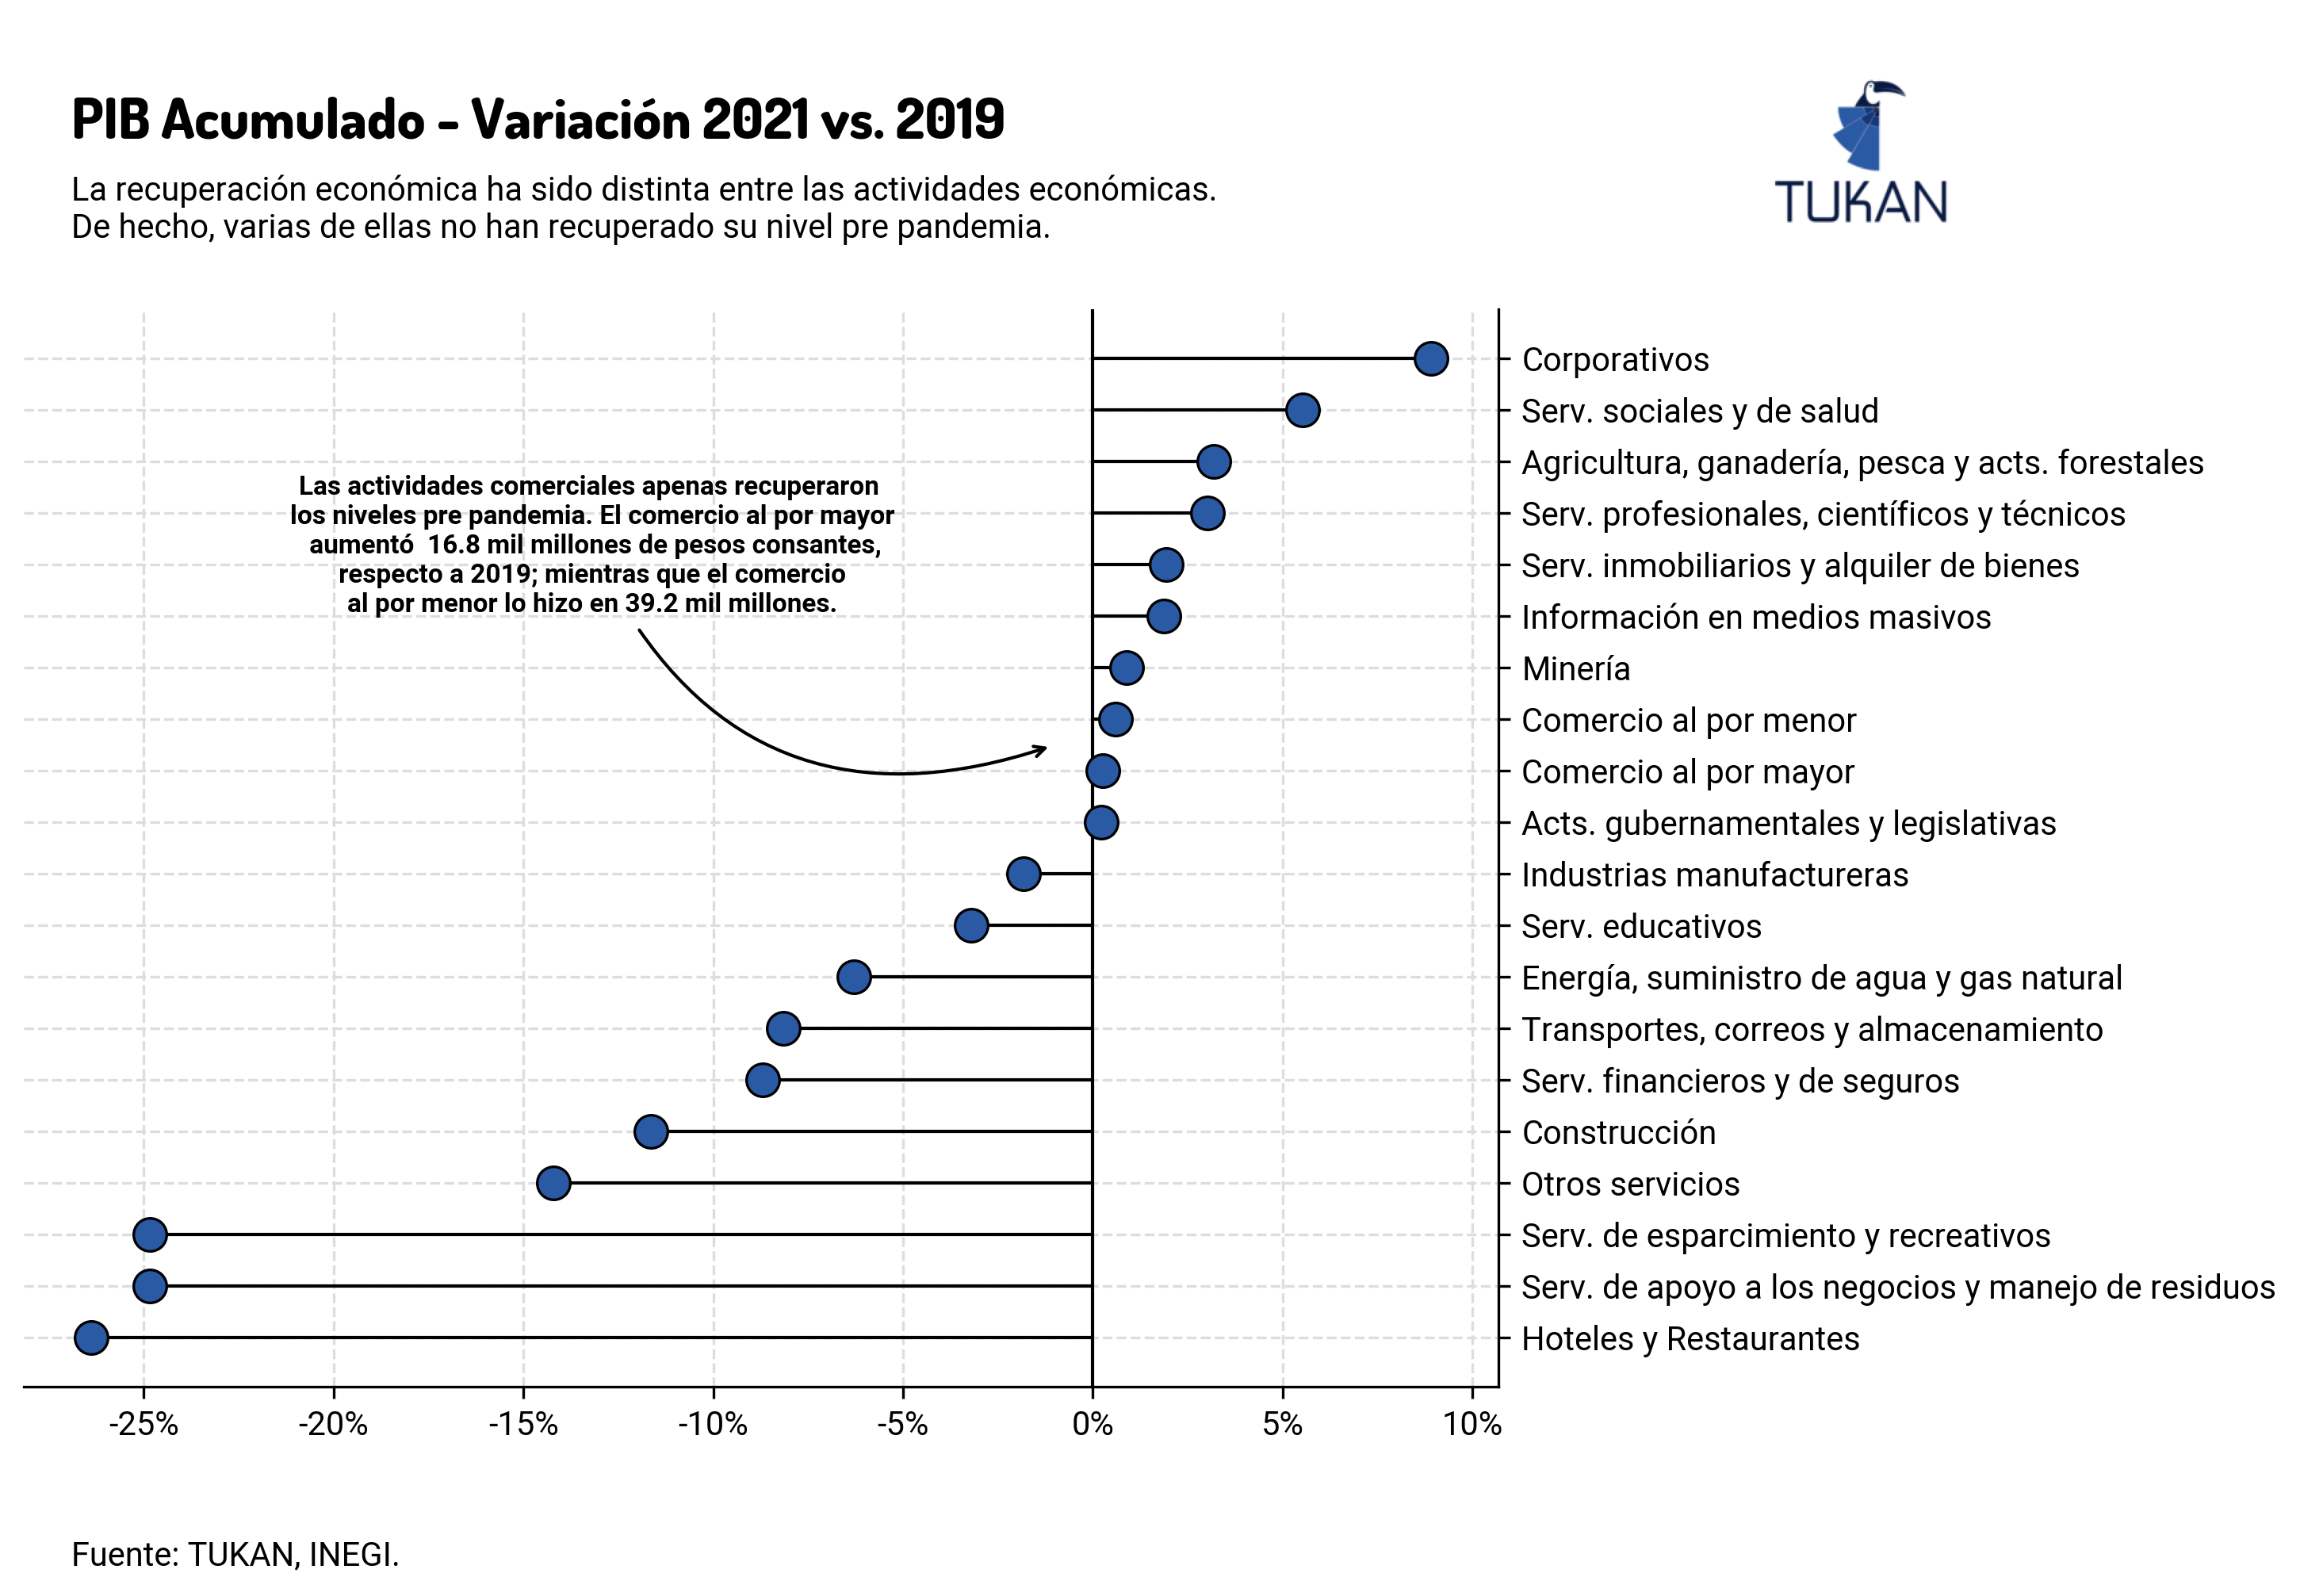

In [55]:
activities_gdp = activities_gdp.sort_values('var_2021_2019', ascending=True)
activities_gdp['p_ref'] =  range(activities_gdp.shape[0]) #plot_reference
activities_gdp.reset_index(drop=True, inplace=True)


labels = activities_gdp['economic_activity'].tolist()

fig = plt.figure(figsize=(8,6), dpi = 300)
ax = plt.subplot(111)

# Change splines
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(False)

# Data to plot
for x in activities_gdp.index:
    if activities_gdp['var_2021_2019'].loc[x]>=0:
        ax.hlines(y=activities_gdp['p_ref'].loc[x], xmin=0, xmax=activities_gdp['var_2021_2019'].loc[x],lw=1, color='black' ,zorder=2)
    else:
        ax.hlines(y=activities_gdp['p_ref'].loc[x], xmin=activities_gdp['var_2021_2019'].loc[x], xmax=0,lw=1, color='black' ,zorder=2)

ax.scatter(activities_gdp['var_2021_2019'],activities_gdp['p_ref'],s=100, edgecolors='black', lw=0.8, zorder=3, label='2021')

# Add gridlines and format to ticks 
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0%}'))
ax.axvline(x=0,lw=1, color='black')
ax.set_yticks(range(activities_gdp.shape[0]))
ax.set_yticklabels(labels)

# Axis ticks on right side
ax.yaxis.tick_right()

# Annotation aux
text_annotation_1 = activities_gdp[activities_gdp['economic_activity']=='Comercio al por mayor']
text_annotation_1 = (text_annotation_1[2021] - text_annotation_1[2019])/1000
text_annotation_1 = text_annotation_1.round(1)

text_annotation_2 = activities_gdp[activities_gdp['economic_activity']=='Comercio al por menor']
text_annotation_2 = (text_annotation_2[2021] - text_annotation_2[2019])/1000
text_annotation_2 = text_annotation_2.round(1)

ax.annotate(
    "Las actividades comerciales apenas recuperaron \nlos niveles pre pandemia. El comercio al por mayor\n aumentó  "+str(abs(text_annotation_1.iloc[0])) +" mil millones de pesos consantes,\n respecto a 2019; mientras que el comercio \nal por menor lo hizo en "+str(abs(text_annotation_2.iloc[0])) +" mil millones.",
    xy=(-0.01,
        11.5),
    xycoords="data",
    xytext=(-140, 60),
    textcoords="offset points",
    color="black",
    size=8,
    va="center",
    ha="center",
    weight="bold",
    arrowprops=dict(
        arrowstyle="->", ec="black", connectionstyle="arc3,rad=.45"
    ),
)

# Add title and subtitle
fig.text(
    0.15,
    1,
    "PIB Acumulado - Variación 2021 vs. 2019",
    size=17,
    weight = "bold",
    family = "Dosis"
)

fig.text(
    0.15,
    0.93,
    "La recuperación económica ha sido distinta entre las actividades económicas.\nDe hecho, varias de ellas no han recuperado su nivel pre pandemia.",
    size=10
)

# Add footer
fig.text(0.15, -0, "Fuente: TUKAN, INEGI.", fontsize=10)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/gdp_activities_pandemic_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

#Tukey's Swag
tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([1, .9, 0.16, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/gdp_activities_pandemic_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/gdp_activities_pandemic_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

In [45]:
text_annotation_1

11    16.8
dtype: float64

In [46]:
text_annotation_2

12    39.2
dtype: float64

### 2020 vs 2019 plot

(-0.5, 190.5, 190.5, -0.5)

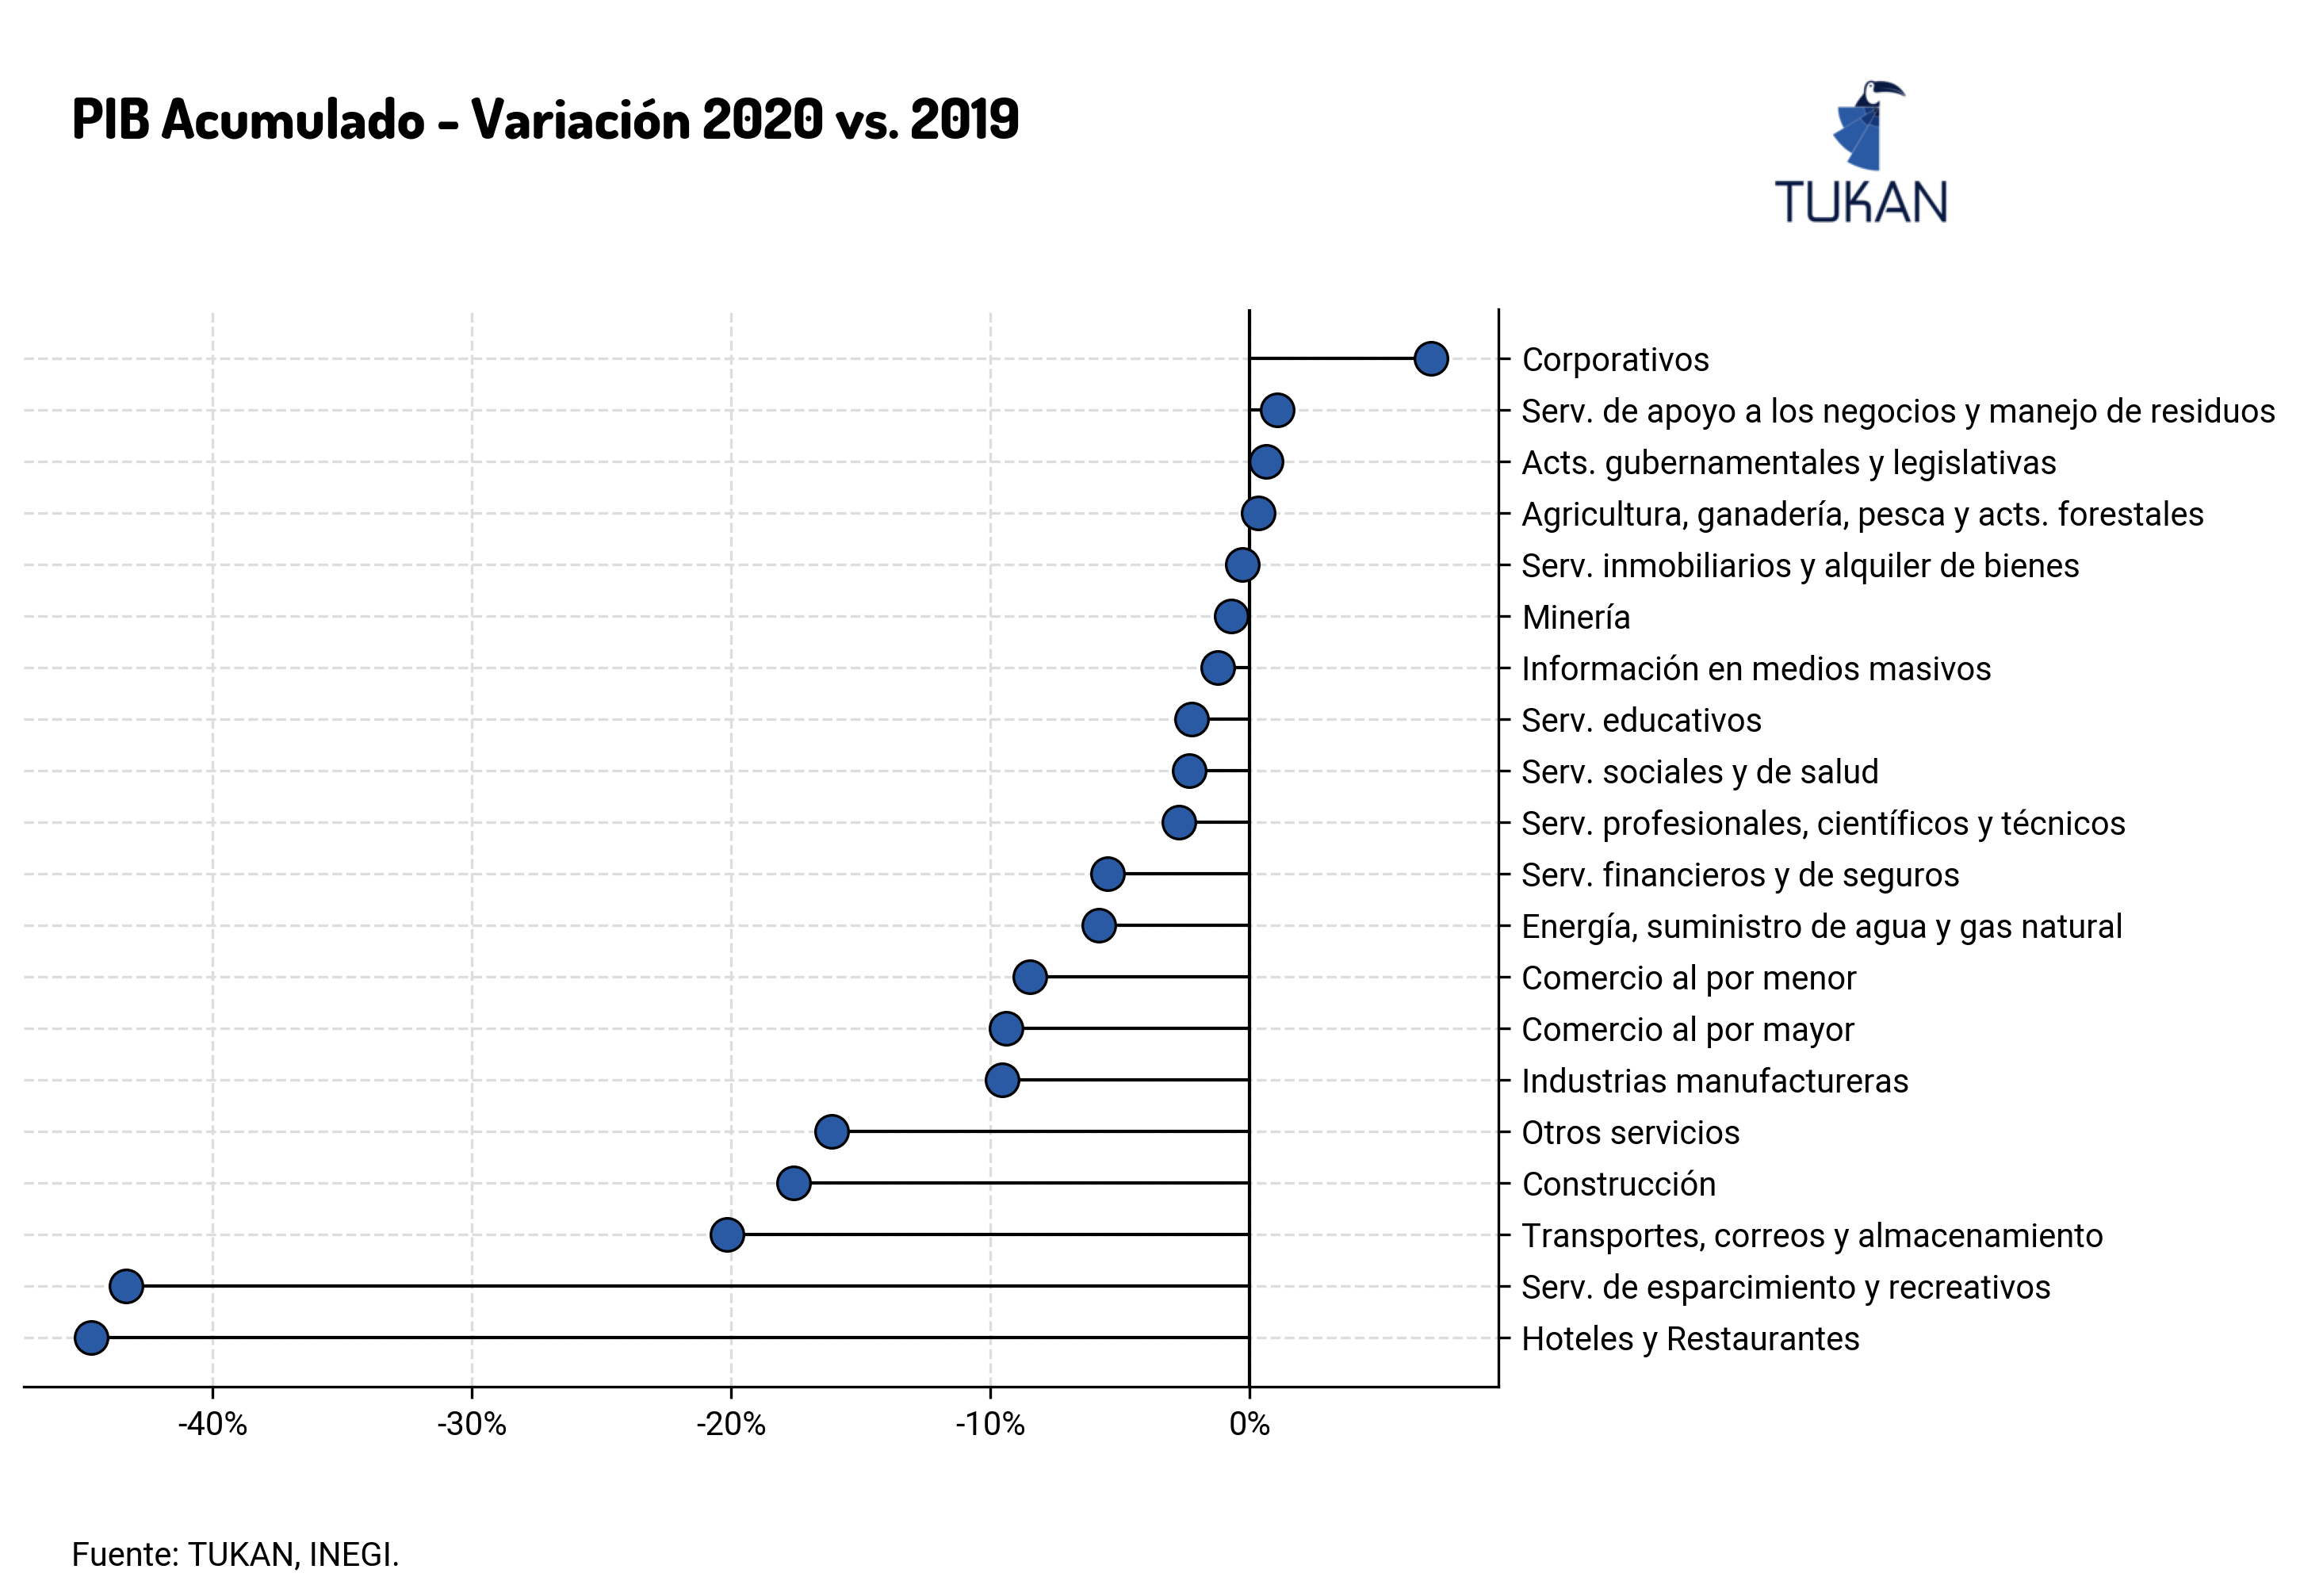

In [27]:
activities_gdp = activities_gdp.sort_values('var_2020_2019', ascending=True)
activities_gdp['p_ref'] =  range(activities_gdp.shape[0]) #plot_reference
activities_gdp.reset_index(drop=True, inplace=True)


labels = activities_gdp['economic_activity'].tolist()

fig = plt.figure(figsize=(8,6), dpi = 300)
ax = plt.subplot(111)

# Change splines
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(False)

# Data to plot
for x in activities_gdp.index:
    if activities_gdp['var_2020_2019'].loc[x]>=0:
        ax.hlines(y=activities_gdp['p_ref'].loc[x], xmin=0, xmax=activities_gdp['var_2020_2019'].loc[x],lw=1, color='black' ,zorder=2)
    else:
        ax.hlines(y=activities_gdp['p_ref'].loc[x], xmin=activities_gdp['var_2020_2019'].loc[x], xmax=0,lw=1, color='black' ,zorder=2)

ax.scatter(activities_gdp['var_2020_2019'],activities_gdp['p_ref'],s=100, edgecolors='black', lw=0.8, zorder=3, label='2021')

# Add gridlines and format to ticks 
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0%}'))
ax.axvline(x=0,lw=1, color='black')
ax.set_yticks(range(activities_gdp.shape[0]))
ax.set_yticklabels(labels)

# Axis ticks on right side
ax.yaxis.tick_right()

# Annotation aux
# text_annotation_1 = activities_gdp[activities_gdp['economic_activity']=='Comercio al por mayor']
# text_annotation_1 = (text_annotation_1[2021] - text_annotation_1[2019])/1000
# text_annotation_1 = text_annotation_1.round(1)

# text_annotation_2 = activities_gdp[activities_gdp['economic_activity']=='Comercio al por menor']
# text_annotation_2 = (text_annotation_2[2021] - text_annotation_2[2019])/1000
# text_annotation_2 = text_annotation_2.round(1)

# ax.annotate(
#     "Las actividades comerciales están cerca de recuperar \nlos niveles pre pandemia. El comercio al por menor\nes menor en  "+str(abs(text_annotation_1.iloc[0])) +" mil millones de pesos, respecto a 2019,\n mientras que el comercio al por menor es inferior en "+str(abs(text_annotation_2.iloc[0])) +" mil millones.",
#     xy=(-0.02,
#         10.5),
#     xycoords="data",
#     xytext=(-140, 60),
#     textcoords="offset points",
#     color="black",
#     size=8,
#     va="center",
#     ha="center",
#     weight="bold",
#     arrowprops=dict(
#         arrowstyle="->", ec="black", connectionstyle="arc3,rad=.45"
#     ),
# )

# Add title and subtitle
fig.text(
    0.15,
    1,
    "PIB Acumulado - Variación 2020 vs. 2019",
    size=17,
    weight = "bold",
    family = "Dosis"
)

# fig.text(
#     0.15,
#     0.93,
#     "La recuperación económica ha sido distinta entre las actividades económicas.\nDe hecho, varias de ellas no han recuperado su nivel pre pandemia.",
#     size=10
# )

# Add footer
fig.text(0.15, -0, "Fuente: TUKAN, INEGI.", fontsize=10)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/gdp_activities_pandemic_no_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

#Tukey's Swag
tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([1, .9, 0.16, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

# plt.savefig(
#     "plots/gdp_activities_pandemic_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

# plt.savefig(
#     "plots/gdp_activities_pandemic_white_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="white",
#     edgecolor="none",
#     transparent=False,
# )